# Parallel programming in GPU with Numba

This notebook is based on a series by [Carlos Costa](https://medium.com/@cdacostaf) split in 4 parts:

- [Part 1](https://towardsdatascience.com/cuda-by-numba-examples-1-4-e0d06651612f) or in [Google Colab](https://colab.research.google.com/drive/1h0Savk8HSIgraT61burXQwbEUDMz4HT6?usp=sharing)
- [Part 2](https://towardsdatascience.com/cuda-by-numba-examples-215c0d285088) or in [Google Colab](https://colab.research.google.com/drive/1GkGLDexnYUnl2ilmwNxAlWAH6Eo5ZK2f?usp=sharing)
- [Part 3](https://towardsdatascience.com/cuda-by-numba-examples-7652412af1ee) or in [Google Colab](https://colab.research.google.com/drive/1iRUQUiHUVdl3jlKzKucxQHQdDPElPb3M?usp=sharing)
- [Part 4](https://towardsdatascience.com/cuda-by-numba-examples-c583474124b0) or in [Google Colab](https://colab.research.google.com/drive/1Eq1Xyuq8hJ440ma_9OBrEVdGm3bIyigt?usp=sharing)


Alternative implementations can be found in:

- [CuPy](https://cupy.dev/): provides functionalities similar to Numba and also some low level features.
- [PyCUDA](https://documen.tician.de/pycuda/): goes deeper in the lower level of direct CUDA API access.
- [cuda-python](https://nvidia.github.io/cuda-python/overview.html): official Nvidia Python API to CUDA, still giving its first steps.

The CUDA programming model is provided [here](https://developer.nvidia.com/blog/cuda-refresher-cuda-programming-model/) and full Numba for CUDA GPUs documentation [here](https://numba.readthedocs.io/en/stable/cuda/index.html).

In [1]:
from time import perf_counter_ns
from cuda import cuda as cc
from numba import cuda as nc
from skimage import data
import warnings
import math
import matplotlib.pyplot as plt
import numpy as np
import numba

%matplotlib inline

In [2]:
print(np.__version__)
print(numba.__version__)
nc.detect()

1.22.4
0.56.0
Found 1 CUDA devices
id 0         b'Quadro M2200'                 [SUPPORTED (DEPRECATED)]
                      Compute Capability: 5.2
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f7796073-49a0-29ce-25a0-5cd1d0ec228a
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported


True

In [3]:
warnings.simplefilter("ignore", numba.NumbaPerformanceWarning)

## Introduction to CUDA through Numba

### Basics of *Host* and *Device* allocation

In [4]:
@nc.jit
def add_scalars(a, b, c):
    c[0] = a + b

In [5]:
dev_c = nc.device_array((1,), np.float32)

blocks = 1
threads = 1
add_scalars[blocks, threads](2.0, 7.0, dev_c)

c = dev_c.copy_to_host()
print(f"2.0 + 7.0 = {c[0]}")

2.0 + 7.0 = 9.0


### Computing an array in the *Device*

In [6]:
@nc.jit
def add_array(a, b, c):
    i = nc.threadIdx.x + nc.blockDim.x * nc.blockIdx.x
    
    if i < a.size:
        c[i] = a[i] + b[i]

In [7]:
N = 18
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

In [8]:
c = a + b
print(c)

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.]


In [9]:
dev_a = nc.to_device(a)
dev_b = nc.to_device(b)
dev_c = nc.device_array_like(a)

In [10]:
threads = 8
blocks = 4
add_array[blocks, threads](dev_a, dev_b, dev_c)

In [11]:
host_c = dev_c.copy_to_host()
np.allclose(c, host_c)

True

### Improvement of previous code

In [12]:
@nc.jit
def add_array_with_grid(a, b, c):
    i = nc.grid(1)
    if i < a.size:
        c[i] = a[i] + b[i]

In [13]:
threads = 8
blocks = 4
add_array_with_grid[blocks, threads](dev_a, dev_b, dev_c)

### Generalizing for any array size

More on this can be found in [Nsight Compute](https://developer.nvidia.com/nsight-compute).

note that blocks == ceil(N / threads)

ensures that blocks * threads >= N

In [14]:
N = 200_000_000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

dev_a = nc.to_device(a)
dev_b = nc.to_device(b)
dev_c = nc.device_array_like(a)

threads = 256
blocks = (N + threads - 1) // threads

add_array[blocks, threads](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
np.allclose(a + b, c)

True

### Side note on GPU attributes

Attributes of a GPU can be accessed with [cuda.cuda.cuDeviceGetAttribute](https://nvidia.github.io/cuda-python/module/cuda.html#cuda.cuda.cuDeviceGetAttribute), where the `cuda` module refers to `cuda-python` package.

In [15]:
# Initialize CUDA Driver API
(_,) = cc.cuInit(0)

In [16]:
# Get attributes
_, DEVICE_NAME = cc.cuDeviceGetName(128, 0)
DEVICE_NAME.decode("ascii").replace("\x00", "")

'Quadro M2200                                                                                                                   '

In [17]:
def get_cudevice_attr(name, dev=cc.CUdevice()):
    attr = getattr(cc.CUdevice_attribute, name)
    return cc.cuDeviceGetAttribute(attr, dev=dev)[1]

In [18]:
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK"))

1024


In [19]:
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_X"))
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_Y"))
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_BLOCK_DIM_Z"))

1024
1024
64


In [20]:
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_X"))
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_Y"))
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MAX_GRID_DIM_Z"))

2147483647
65535
65535


In [21]:
print(get_cudevice_attr("CU_DEVICE_ATTRIBUTE_MULTIPROCESSOR_COUNT"))

8


### Grid-stride *GS* loops approach

More on this can be found [here](https://developer.nvidia.com/blog/cuda-pro-tip-write-flexible-kernels-grid-stride-loops/).

In [22]:
@nc.jit
def add_array_gs(a, b, c):
    i_start = nc.grid(1)
    threads_per_grid = nc.blockDim.x * nc.gridDim.x
    for i in range(i_start, a.size, threads_per_grid):
        c[i] = a[i] + b[i]

Use 32 * multiple of streaming multiprocessors

32 * 80 * 256 < 1_000_000 so one thread will process more than one array element

In [23]:
N = 200_000_000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

dev_a = nc.to_device(a)
dev_b = nc.to_device(b)
dev_c = nc.device_array_like(a)

threads = 256
blocks = 32 * 80
add_array_gs[blocks, threads](dev_a, dev_b, dev_c)

c = dev_c.copy_to_host()
np.allclose(a + b, c)

True

### Performance of CUDA kernels

More about this [here](https://developer.nvidia.com/blog/how-implement-performance-metrics-cuda-cc/).

In [24]:
@nc.jit
def add_array_linear(a, b, c):
    i = nc.grid(1)
    if i < a.size:
        c[i] = a[i] + b[i]


@nc.jit
def add_array_gs(a, b, c):
    i_start = nc.grid(1)
    threads_per_grid = nc.blockDim.x * nc.gridDim.x
    for i in range(i_start, a.size, threads_per_grid):
        c[i] = a[i] + b[i]

In [25]:
N = 100_000_000
a = np.arange(N, dtype=np.float32)
b = np.arange(N, dtype=np.float32)

dev_a = nc.to_device(a)
dev_b = nc.to_device(b)
dev_c = nc.device_array_like(a)

In [26]:
threads_linear = 256
blocks_linear = (N + threads_linear - 1) // threads_linear
add_array_linear[blocks_linear, threads_linear](dev_a, dev_b, dev_c)
nc.synchronize()

threads_gs = 256
blocks_gs = 32 * 80
add_array_gs[blocks_gs, threads_gs](dev_a, dev_b, dev_c)
nc.synchronize()

In [27]:
def performance(f, a, b, c):
    timing = np.empty(101)

    for i in range(timing.size):
        tic = perf_counter_ns()
        f(a, b, c)
        nc.synchronize()
        toc = perf_counter_ns()
        timing[i] = toc - tic

    timing *= 1e-6
    gflops = 1e-9 * a.size * 1e3 / timing.mean()

    print(f"Elapsed: {timing.mean():.1f} ± {timing.std():.1f} ms")
    print(f"GFLOP/s: {gflops:.2f}")

In [28]:
kernel = add_array_linear[blocks_linear, threads_linear]
performance(kernel, dev_a, dev_b, dev_c)

Elapsed: 16.9 ± 0.4 ms
GFLOP/s: 5.92


In [29]:
kernel = add_array_gs[blocks_gs, threads_gs]
performance(kernel, dev_a, dev_b, dev_c)

Elapsed: 18.1 ± 0.4 ms
GFLOP/s: 5.52


### Going towards 2D processing

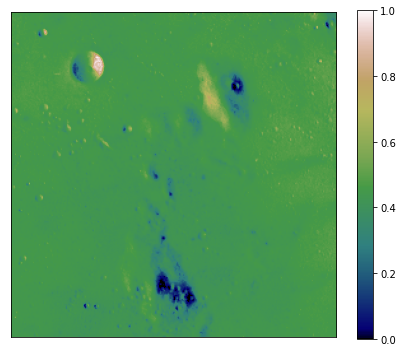

In [30]:
moon = data.moon().astype(np.float32) / 255.

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(moon, cmap="gist_earth")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(im)
fig.tight_layout()

In [31]:
@nc.jit
def adjust_log(inp, gain, out):
    # The first index is the fastest dimension
    ix, iy = nc.grid(2)

    #  threads per grid dimension
    threads_per_grid_x, threads_per_grid_y = nc.gridsize(2)
    
    # The last index is the fastest dimension
    n0, n1 = inp.shape

    # Stride each dimension independently
    for i0 in range(iy, n0, threads_per_grid_y):
        for i1 in range(ix, n1, threads_per_grid_x):
            out[i0, i1] = gain * math.log2(1.0 + inp[i0, i1])

In [32]:
threads_per_block_2d = (16, 16)
blocks_per_grid_2d = (64, 64)

moon_gpu = nc.to_device(moon)
moon_corr_gpu = nc.device_array_like(moon_gpu)

adjust_log[blocks_per_grid_2d, threads_per_block_2d](moon_gpu, 1.0, moon_corr_gpu)
moon_corr = moon_corr_gpu.copy_to_host()

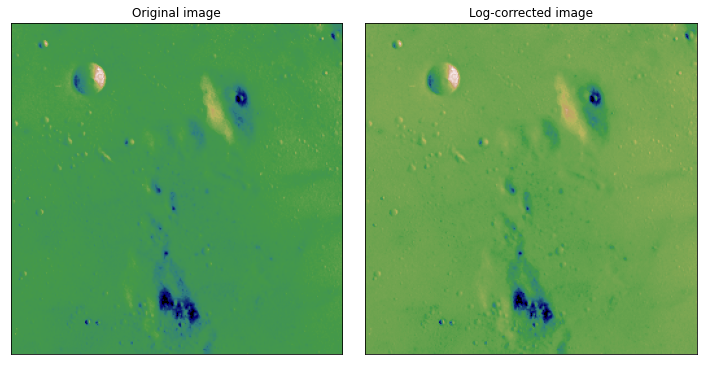

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(moon, cmap="gist_earth")
ax2.imshow(moon_corr, cmap="gist_earth")
ax1.set(title="Original image")
ax2.set(title="Log-corrected image")

for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.tight_layout()

## Thread cooperation

### Simple parallel reduction

In [34]:
def sum_cpu(array):
    s = 0.0
    for i in range(array.size):
        s += array[i]
    return s 

Use 32 * multiple of streaming multiprocessors

In [35]:
threads_per_block = 1024
blocks_per_grid = 32 * 80

In [36]:
@nc.jit
def reduce_naive(array, partial_reduction):
    i_start = nc.grid(1)
    threads_per_grid = nc.blockDim.x * nc.gridDim.x
    s_thread = 0.0
    for i_arr in range(i_start, array.size, threads_per_grid):
        s_thread += array[i_arr]

    # We need to create a special *shared* array which will be able to be read
    # from and written to by every thread in the block. Each block will have its
    # own shared array. See the warning below!
    s_block = nc.shared.array((threads_per_block,), numba.float32)
    
    # We now store the local temporary sum of a single the thread into the
    # shared array. Since the shared array is sized
    #     threads_per_block == blockDim.x
    # (1024 in this example), we should index it with `threadIdx.x`.
    tid = nc.threadIdx.x
    s_block[tid] = s_thread
    
    # The next line synchronizes the threads in a block. It ensures that after
    # that line, all values have been written to `s_block`.
    nc.syncthreads()

    # Finally, we need to sum the values from all threads to yield a single
    # value per block. We only need one thread for this.
    if tid == 0:
        # We store the sum of the elements of the shared array in its first
        # coordinate
        for i in range(1, threads_per_block):
            s_block[0] += s_block[i]
        # Move this partial sum to the output. Only one thread is writing here.
        partial_reduction[nc.blockIdx.x] = s_block[0]

In [37]:
N = 200_000_000
a = np.arange(N, dtype=np.float32)
a /= a.sum() # a will have sum = 1 (to float32 precision)

s_cpu = a.sum()

In [38]:
def perf_counter_ms_cuda(f, post=None, count=21):
    timing = np.empty(count)
    for i in range(count):
        tic = perf_counter_ns()
        rets = f()
        nc.synchronize()
        toc = perf_counter_ns()
        
        if post is not None:
            post(rets)    
        
        timing[i] = toc - tic

    timing *= 1.0e-06
    return timing


In [39]:
timing = perf_counter_ms_cuda(lambda: a.sum(), post=None, count=21)
print(f"Elapsed time CPU: {timing.mean():.0f} ± {timing.std():.0f} ms")

Elapsed time CPU: 112 ± 3 ms


In [40]:
# del dev_a #, dev_b, dev_c

In [41]:
dev_a = nc.to_device(a)
dev_partial_reduction = nc.device_array((blocks_per_grid,), dtype=a.dtype)

reduce_naive[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
s = dev_partial_reduction.copy_to_host().sum()  # Final reduction in CPU

np.isclose(s, s_cpu)  # Ensure we have the right number

True

In [42]:
def f():
    reduce_naive[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
    return dev_partial_reduction.copy_to_host().sum()


def post(s):
    assert np.isclose(s, s_cpu)


timing = perf_counter_ms_cuda(f, post=post, count=21)
print(f"Elapsed time CPU: {timing.mean():.0f} ± {timing.std():.0f} ms")

Elapsed time CPU: 23 ± 2 ms


### Binary tree improvement

In [43]:
# Example 2.2: Better reduction
@nc.jit
def reduce_better(array, partial_reduction):
    i_start = nc.grid(1)
    threads_per_grid = nc.blockDim.x * nc.gridDim.x
    s_thread = 0.0
    for i_arr in range(i_start, array.size, threads_per_grid):
        s_thread += array[i_arr]

    # We need to create a special *shared* array which will be able to be read
    # from and written to by every thread in the block. Each block will have its
    # own shared array. See the warning below!
    s_block = nc.shared.array((threads_per_block,), numba.float32)
    
    # We now store the local temporary sum of the thread into the shared array.
    # Since the shared array is sized threads_per_block == blockDim.x,
    # we should index it with `threadIdx.x`.
    tid = nc.threadIdx.x
    s_block[tid] = s_thread
    
    # The next line synchronizes the threads in a block. It ensures that after
    # that line, all values have been written to `s_block`.
    nc.syncthreads()

    i = nc.blockDim.x // 2
    while (i > 0):
        if (tid < i):
            s_block[tid] += s_block[tid + i]
        nc.syncthreads()
        i //= 2

    if tid == 0:
        partial_reduction[nc.blockIdx.x] = s_block[0]

In [44]:
reduce_better[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
s = dev_partial_reduction.copy_to_host().sum()  # Final reduction in CPU

np.isclose(s, s_cpu)

True

In [45]:
def f():
    reduce_better[blocks_per_grid, threads_per_block](dev_a, dev_partial_reduction)
    return dev_partial_reduction.copy_to_host().sum()


def post(s):
    assert np.isclose(s, s_cpu)


timing = perf_counter_ms_cuda(f, post=post, count=21)
print(f"Elapsed time CPU: {timing.mean():.0f} ± {timing.std():.0f} ms")

Elapsed time CPU: 14 ± 0 ms


### Numba built-in reduce

In [46]:
@nc.reduce
def reduce_numba(a, b):
    return a + b

In [47]:
s = reduce_numba(dev_a)

np.isclose(s, s_cpu)

True

In [48]:
def f():
    return reduce_numba(dev_a)


def post(s):
    assert np.isclose(s, s_cpu)


timing = perf_counter_ms_cuda(f, post=post, count=21)
print(f"Elapsed time CPU: {timing.mean():.0f} ± {timing.std():.0f} ms")

Elapsed time CPU: 12 ± 1 ms


In [49]:
dev_s = nc.device_array((1,), dtype=s)

reduce_numba(dev_a, res=dev_s)

s = dev_s.copy_to_host()[0]
np.isclose(s, s_cpu)

True

### Reduction of 2D data

In [50]:
threads_per_block_2d = (16, 16)
blocks_per_grid_2d = (64, 64)

# Total number of threads in a 2D block (has to be an int)
shared_array_len = int(np.prod(threads_per_block_2d))  

In [51]:
@nc.jit
def reduce2d(array2d, partial_reduction2d):
    ix, iy = nc.grid(2)
    threads_per_grid_x, threads_per_grid_y = nc.gridsize(2)

    s_thread = 0.0
    for i0 in range(iy, array2d.shape[0], threads_per_grid_x):
        for i1 in range(ix, array2d.shape[1], threads_per_grid_y):
            s_thread += array2d[i0, i1]

    # Allocate shared array
    s_block = nc.shared.array(shared_array_len, numba.float32)

    # Index the threads linearly: each tid identifies a unique thread in the
    # 2D grid.
    tid = nc.threadIdx.x + nc.blockDim.x * nc.threadIdx.y
    s_block[tid] = s_thread

    nc.syncthreads()

    # We can use the same smart reduction algorithm by remembering that
    #     shared_array_len == blockDim.x * cuda.blockDim.y
    # So we just need to start our indexing accordingly.
    i = (nc.blockDim.x * nc.blockDim.y) // 2
    while (i != 0):
        if (tid < i):
            s_block[tid] += s_block[tid + i]
        nc.syncthreads()
        i //= 2
    
    # Store reduction in a 2D array the same size as the 2D blocks
    if tid == 0:
        partial_reduction2d[nc.blockIdx.x, nc.blockIdx.y] = s_block[0]

In [52]:
N_2D = (20_000, 20_000)
a_2d = np.arange(np.prod(N_2D), dtype=np.float32).reshape(N_2D)
a_2d /= a_2d.sum() # a_2d will have sum = 1 (to float32 precision)

s_2d_cpu = a_2d.sum()

In [53]:
dev_a_2d = nc.to_device(a_2d)
dev_partial_reduction_2d = nc.device_array(blocks_per_grid_2d, dtype=a.dtype)

reduce2d[blocks_per_grid_2d, threads_per_block_2d](dev_a_2d, dev_partial_reduction_2d)
s_2d = dev_partial_reduction_2d.copy_to_host().sum()  # Final reduction in CPU

np.isclose(s_2d, s_2d_cpu)  # Ensure we have the right number

True

In [54]:
def f():
    reduce2d[blocks_per_grid_2d, threads_per_block_2d](dev_a_2d, dev_partial_reduction_2d)
    return dev_partial_reduction_2d.copy_to_host().sum()


def post(s_2d):
    assert np.isclose(s_2d, s_2d_cpu)


timing = perf_counter_ms_cuda(f, post=post, count=21)
print(f"Elapsed time CPU: {timing.mean():.0f} ± {timing.std():.0f} ms")

Elapsed time CPU: 31 ± 0 ms


### Device functions

In [59]:
threads_16 = 32

In [60]:
@nc.jit(device=True, inline=True)
def amplitude(ix, iy):
    return (1 + math.sin(2 * math.pi * (ix - 64) / 256)) * (
        1 + math.sin(2 * math.pi * (iy - 64) / 256)
    )

# Example 2.5a: 2D Shared Array
@nc.jit
def blobs_2d(array2d):
    ix, iy = nc.grid(2)
    tix, tiy = nc.threadIdx.x, nc.threadIdx.y

    shared = nc.shared.array((threads_16, threads_16), numba.float32)
    shared[tiy, tix] = amplitude(iy, ix)
    nc.syncthreads()

    array2d[iy, ix] = shared[15 - tiy, 15 - tix]

# Example 2.5b: 2D Shared Array without synchronize
@nc.jit
def blobs_2d_wrong(array2d):
    ix, iy = nc.grid(2)
    tix, tiy = nc.threadIdx.x, nc.threadIdx.y

    shared = nc.shared.array((threads_16, threads_16), numba.float32)
    shared[tiy, tix] = amplitude(iy, ix)

    # When we don't sync threads, we may have not written to shared
    # yet, or even have overwritten it by the time we write to array2d
    array2d[iy, ix] = shared[15 - tiy, 15 - tix]

In [66]:
N_img = 1024
blocks = (N_img // threads_16, N_img // threads_16)
threads = (threads_16, threads_16)

dev_image = nc.device_array((N_img, N_img), dtype=np.float32)
dev_image_wrong = nc.device_array((N_img, N_img), dtype=np.float32)

blobs_2d[blocks, threads](dev_image)
blobs_2d_wrong[blocks, threads](dev_image_wrong)

image = dev_image.copy_to_host()
image_wrong = dev_image_wrong.copy_to_host()

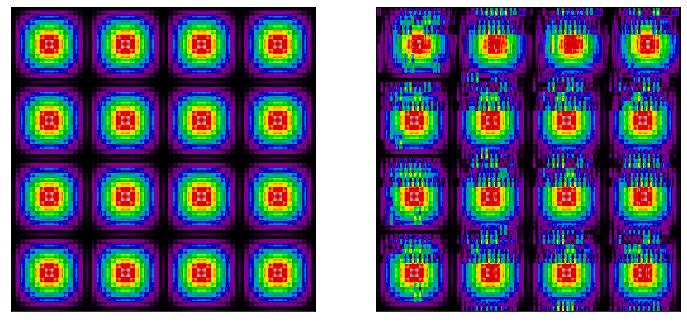

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(image.T, cmap="nipy_spectral")
ax2.imshow(image_wrong.T, cmap="nipy_spectral")
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

## Streams and events

## Atomic instructions and *mutex*